# Start Pooling

In [2]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import scipy.optimize as sco
import random
from pathlib import Path
import pickle

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import functions as fct

## Define Countries and Variables for Cat Bond Development

In [3]:
#choose country
countries = [480, 212, 882, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585] #[480, 212, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 882, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

countries_str = ['MUS', 'DMA', 'WSM', 'HIT', 'VCT', 'ATG', 'JAM', 'BRB', 'LCA', 'KNA', 'GRD', 'DOM', 'BHS', 'VUT', 'FJI', 'TTO', 'CUB', 'NIU', 'BLZ', 'TON', 'SLB', 'COM', 'COK', 'MHL', 'PLW']
countries_str_x_label = ['MUS', 'DMA', 'WSM', 'HIT', 'VCT', 'ATG', 'JAM', 'BRB', 'LCA', 'KNA', 'GRD', 'DOM', 'BHS', 'VUT', 'FJI', 'TTO', 'CUB', 'NIU', 'BLZ', 'TON', 'SLB', 'COM', 'COK', 'MHL', 'PLW', 'Pool']

scenario_1 = [[480, 212, 882, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]] 
scenario_2 = [[480, 212, 332, 670, 388, 52, 659, 214, 44, 242, 780, 192, 570], [882, 28, 662, 308, 548, 84, 776, 90, 174, 184, 584, 585]]
scenario_3 = [[184, 584, 585], [480, 332, 388, 52, 662, 659, 214, 44, 242, 780, 192, 570], [212, 882, 670, 28, 308, 548, 84, 776, 90, 174]]
scenario_4 = [[184, 584, 585], [480, 332, 388, 52, 44, 570], [882, 28, 662, 308, 548, 84, 90, 174], [212, 670, 659, 214, 242, 780, 192, 776]]
scenario_5 = [[184, 584, 585], [214, 780, 192, 570], [882, 659, 308, 84, 174], [480, 332, 388, 52, 662, 44, 242], [212, 670, 28, 548, 776, 90]]
scenario_5_add = [[184, 584, 585], [214, 780, 192, 570], [882, 659, 308, 84, 174], [480, 332, 388, 52, 662, 44, 242], [212, 670, 28, 548, 776, 90]]
#set risk free rate, either single value or array
rf_rates = 0.00
#set risk muliplier reported by artems
artemis_multiplier = 4.54
#set sharpe ratio to beat
target_sharpe = 0.5
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#define bond setting
lower_share = 0.05
prot_rp = 250


## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

In [4]:
sng_ann_ret_df_ibrd = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/sng_returns_ibrd.csv")
sng_ann_ret_df_regression = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/sng_returns_regression.csv")
sng_ann_ret_df_artemis = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/sng_returns_artemis.csv")
sng_ann_ret_df_required = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/sng_returns_required.csv")
output_path = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/bond_metrics_sng_dic.pkl")
with open(output_path, "rb") as file:
    bond_metrics_sng_dic = pickle.load(file)

sng_ann_ret_required = sng_ann_ret_df_required.to_dict('series')
sng_ann_ret_artemis = sng_ann_ret_df_artemis.to_dict('series')
sng_ann_ret_regression = sng_ann_ret_df_regression.to_dict('series')
sng_ann_ret_ibrd = sng_ann_ret_df_ibrd.to_dict('series')

nominal_sng_dic_df = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/nominal_dic_df.csv")
# Specify the output path
output_path = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/pay_dam_df_dic.pkl")
with open(output_path, "rb") as file:
    pay_dam_df_sng_dic = pickle.load(file)

nominal_sng_dic = dict(zip(nominal_sng_dic_df["Key"], nominal_sng_dic_df["Value"]))

### Create Multi-Country bond

In [5]:
tranches_array = np.array([50, 250, 1000])

ncf_s1 = {}
premiums_s1 = {}
premium_dic_s1 = {}
nominal_s1 = {}
es_metrics_s1 = {}
MES_cty_s1 = {}
tranches_s1 = {}

i = 0
for pool in scenario_1:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s1[str(i)], premiums_s1[str(i)], premium_dic_s1[str(i)], nominal_s1[str(i)], es_metrics_s1[str(i)], MES_cty_s1[str(i)], tranches_s1[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True)
        

ncf_s2 = {}
premiums_s2 = {}
premium_dic_s2 = {}
nominal_s2 = {}
es_metrics_s2 = {}
MES_cty_s2 = {}
tranches_s2 = {}

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s2[str(i)], premiums_s2[str(i)], premium_dic_s2[str(i)], nominal_s2[str(i)], es_metrics_s2[str(i)], MES_cty_s2[str(i)], tranches_s2[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True)
        

ncf_s3 = {}
premiums_s3 = {}
premium_dic_s3 = {}
nominal_s3 = {}
es_metrics_s3 = {}
MES_cty_s3 = {}
tranches_s3 = {}

i = 0
for pool in scenario_3:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s3[str(i)], premiums_s3[str(i)], premium_dic_s3[str(i)], nominal_s3[str(i)], es_metrics_s3[str(i)], MES_cty_s3[str(i)], tranches_s3[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True)
        

ncf_s4 = {}
premiums_s4 = {}
premium_dic_s4 = {}
nominal_s4 = {}
es_metrics_s4 = {}
MES_cty_s4 = {}
tranches_s4 = {}

i = 0
for pool in scenario_4:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s4[str(i)], premiums_s4[str(i)], premium_dic_s4[str(i)], nominal_s4[str(i)], es_metrics_s4[str(i)], MES_cty_s4[str(i)], tranches_s4[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True)
        

ncf_s5 = {}
premiums_s5 = {}
premium_dic_s5 = {}
nominal_s5 = {}
es_metrics_s5 = {}
MES_cty_s5 = {}
tranches_s5 = {}

i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5[str(i)], premiums_s5[str(i)], premium_dic_s5[str(i)], nominal_s5[str(i)], es_metrics_s5[str(i)], MES_cty_s5[str(i)], tranches_s5[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True) 

ncf_s5_a = {}
premiums_s5_a = {}
premium_dic_s5_a = {}
nominal_s5_a = {}
es_metrics_s5_a = {}
MES_cty_s5_a = {}
tranches_s5_a = {}

i = 0
for pool in scenario_5_add:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a[str(i)], premiums_s5_a[str(i)], premium_dic_s5_a[str(i)], nominal_s5_a[str(i)], es_metrics_s5_a[str(i)], MES_cty_s5_a[str(i)], tranches_s5_a[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, prem_corr=0.01)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 36.98%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 34.79%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.41%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 25.55%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 34.87%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 49.54%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 25.55%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 32.99%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.65%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 24.93%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 25.55%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 22.33%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 42.52%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 36.71%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 39.35%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 25.55%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 22.33%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 42.52%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 36.71%


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 39.35%


In [6]:
s1_tranches_ann_ret_regr = {}
s1_tranches_ann_ret_ibrd ={}
s1_tranches_ann_ret_requ ={}
s1_tranches_ann_ret_arte ={}

for key in ncf_s1["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s1:
            s1_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s1[pool]['regression'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s1[pool]['ibrd'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s1[pool]['required'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s1[pool]['artemis'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]

s2_tranches_ann_ret_regr = {}
s2_tranches_ann_ret_ibrd = {}
s2_tranches_ann_ret_requ = {}
s2_tranches_ann_ret_arte = {}

for key in ncf_s2["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s2:
            s2_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s2[pool]['regression'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s2[pool]['ibrd'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s2[pool]['required'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s2[pool]['artemis'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]

s3_tranches_ann_ret_regr = {}
s3_tranches_ann_ret_ibrd = {}
s3_tranches_ann_ret_requ = {}
s3_tranches_ann_ret_arte = {}

for key in ncf_s3["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s3:
            s3_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s3[pool]['regression'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s3[pool]['ibrd'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s3[pool]['required'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s3[pool]['artemis'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]


s4_tranches_ann_ret_regr = {}
s4_tranches_ann_ret_ibrd = {}
s4_tranches_ann_ret_requ = {}
s4_tranches_ann_ret_arte = {}

for key in ncf_s4["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s4:
            s4_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s4[pool]['regression'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s4[pool]['ibrd'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s4[pool]['required'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s4[pool]['artemis'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]

s5_tranches_ann_ret_regr = {}
s5_tranches_ann_ret_ibrd = {}
s5_tranches_ann_ret_requ = {}
s5_tranches_ann_ret_arte = {}

for key in ncf_s5["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5:
            s5_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5[pool]['regression'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5[pool]['ibrd'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5[pool]['required'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s5[pool]['artemis'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]


s5_a_tranches_ann_ret_regr = {}
s5_a_tranches_ann_ret_ibrd = {}
s5_a_tranches_ann_ret_requ = {}
s5_a_tranches_ann_ret_arte = {}

for key in ncf_s5_a["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a:
            s5_a_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a[pool]['regression'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a[pool]['ibrd'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a[pool]['required'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s5_a[pool]['artemis'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]




s1_ann_ret_regr = {}
s1_ann_ret_ibrd = {}
s1_ann_ret_requ = {}
s1_ann_ret_arte = {}
for pool in ncf_s1:
    s1_ann_ret_regr[pool] = 0
    s1_ann_ret_ibrd[pool] = 0
    s1_ann_ret_requ[pool] = 0
    s1_ann_ret_arte[pool] = 0
    for rp in ncf_s1[pool]['regression']:
        if rp != 'Total':
            s1_ann_ret_regr[pool] += ncf_s1[pool]['regression'][rp]
            s1_ann_ret_ibrd[pool] += ncf_s1[pool]['ibrd'][rp]
            s1_ann_ret_requ[pool] += ncf_s1[pool]['required'][rp]
            s1_ann_ret_arte[pool] += ncf_s1[pool]['artemis'][rp]


s2_ann_ret_regr = {}
s2_ann_ret_ibrd = {}
s2_ann_ret_requ = {}
s2_ann_ret_arte = {}
for pool in ncf_s2:
    s2_ann_ret_regr[pool] = 0
    s2_ann_ret_ibrd[pool] = 0
    s2_ann_ret_requ[pool] = 0
    s2_ann_ret_arte[pool] = 0
    for rp in ncf_s2[pool]['regression']:
        if rp != 'Total':
            s2_ann_ret_regr[pool] += ncf_s2[pool]['regression'][rp]
            s2_ann_ret_ibrd[pool] += ncf_s2[pool]['ibrd'][rp]
            s2_ann_ret_requ[pool] += ncf_s2[pool]['required'][rp]
            s2_ann_ret_arte[pool] += ncf_s2[pool]['artemis'][rp]


s3_ann_ret_regr = {}
s3_ann_ret_ibrd = {}
s3_ann_ret_requ = {}
s3_ann_ret_arte = {}
for pool in ncf_s3:
    s3_ann_ret_regr[pool] = 0
    s3_ann_ret_ibrd[pool] = 0
    s3_ann_ret_requ[pool] = 0
    s3_ann_ret_arte[pool] = 0
    for rp in ncf_s3[pool]['regression']:
        if rp != 'Total':
            s3_ann_ret_regr[pool] += ncf_s3[pool]['regression'][rp]
            s3_ann_ret_ibrd[pool] += ncf_s3[pool]['ibrd'][rp]
            s3_ann_ret_requ[pool] += ncf_s3[pool]['required'][rp]
            s3_ann_ret_arte[pool] += ncf_s3[pool]['artemis'][rp]


s4_ann_ret_regr = {}
s4_ann_ret_ibrd = {}
s4_ann_ret_requ = {}
s4_ann_ret_arte = {}
for pool in ncf_s4:
    s4_ann_ret_regr[pool] = 0
    s4_ann_ret_ibrd[pool] = 0
    s4_ann_ret_requ[pool] = 0
    s4_ann_ret_arte[pool] = 0
    for rp in ncf_s4[pool]['regression']:
        if rp != 'Total':
            s4_ann_ret_regr[pool] += ncf_s4[pool]['regression'][rp]
            s4_ann_ret_ibrd[pool] += ncf_s4[pool]['ibrd'][rp]
            s4_ann_ret_requ[pool] += ncf_s4[pool]['required'][rp]
            s4_ann_ret_arte[pool] += ncf_s4[pool]['artemis'][rp]


s5_ann_ret_regr = {}
s5_ann_ret_ibrd = {}
s5_ann_ret_requ = {}
s5_ann_ret_arte = {}
for pool in ncf_s5:
    s5_ann_ret_regr[pool] = 0
    s5_ann_ret_ibrd[pool] = 0
    s5_ann_ret_requ[pool] = 0
    s5_ann_ret_arte[pool] = 0
    for rp in ncf_s5[pool]['regression']:
        if rp != 'Total':
            s5_ann_ret_regr[pool] += ncf_s5[pool]['regression'][rp]
            s5_ann_ret_ibrd[pool] += ncf_s5[pool]['ibrd'][rp]
            s5_ann_ret_requ[pool] += ncf_s5[pool]['required'][rp]
            s5_ann_ret_arte[pool] += ncf_s5[pool]['artemis'][rp]

s5_a_ann_ret_regr = {}
s5_a_ann_ret_ibrd = {}
s5_a_ann_ret_requ = {}
s5_a_ann_ret_arte = {}
for pool in ncf_s5_a:
    s5_a_ann_ret_regr[pool] = 0
    s5_a_ann_ret_ibrd[pool] = 0
    s5_a_ann_ret_requ[pool] = 0
    s5_a_ann_ret_arte[pool] = 0
    for rp in ncf_s5_a[pool]['regression']:
        if rp != 'Total':
            s5_a_ann_ret_regr[pool] += ncf_s5_a[pool]['regression'][rp]
            s5_a_ann_ret_ibrd[pool] += ncf_s5_a[pool]['ibrd'][rp]
            s5_a_ann_ret_requ[pool] += ncf_s5_a[pool]['required'][rp]
            s5_a_ann_ret_arte[pool] += ncf_s5_a[pool]['artemis'][rp]



Sng Premiums ibrd: 4055763756.926774; 1.0
P2 Premiums ibrd: 2633711061.4789524; 0.6493748697716625
P3 Premiums ibrd: 2648594178.7073393; 0.6530444911106688
P4 Premiums ibrd: 2649476523.7188582; 0.6532620444654499
P5 Premiums ibrd: 2808029258.7706366; 0.6923552324700492
P6 Premiums ibrd: 2823850465.511788; 0.6962561516777152
P6A Premiums ibrd: 3399631831.7116117; 0.8382223510690028
Sng Premiums regression: 5658135451.097913; 1.0
P2 Premiums regression: 4335291310.62682; 0.7662049359008528
P3 Premiums regression: 4397694946.337467; 0.7772339464733267
P4 Premiums regression: 4394193711.338936; 0.7766151498699594
P5 Premiums regression: 4672757737.64452; 0.8258476273730441
P6 Premiums regression: 4696601840.851067; 0.8300617546968996
P6A Premiums regression: 5272383207.050891; 0.9318234341717342
Sng Premiums required: 6067103683.571421; 1.0
P2 Premiums required: 3996275621.1105337; 0.6586793022726312
P3 Premiums required: 4055455223.4518247; 0.6684334791299574
P4 Premiums required: 4055167

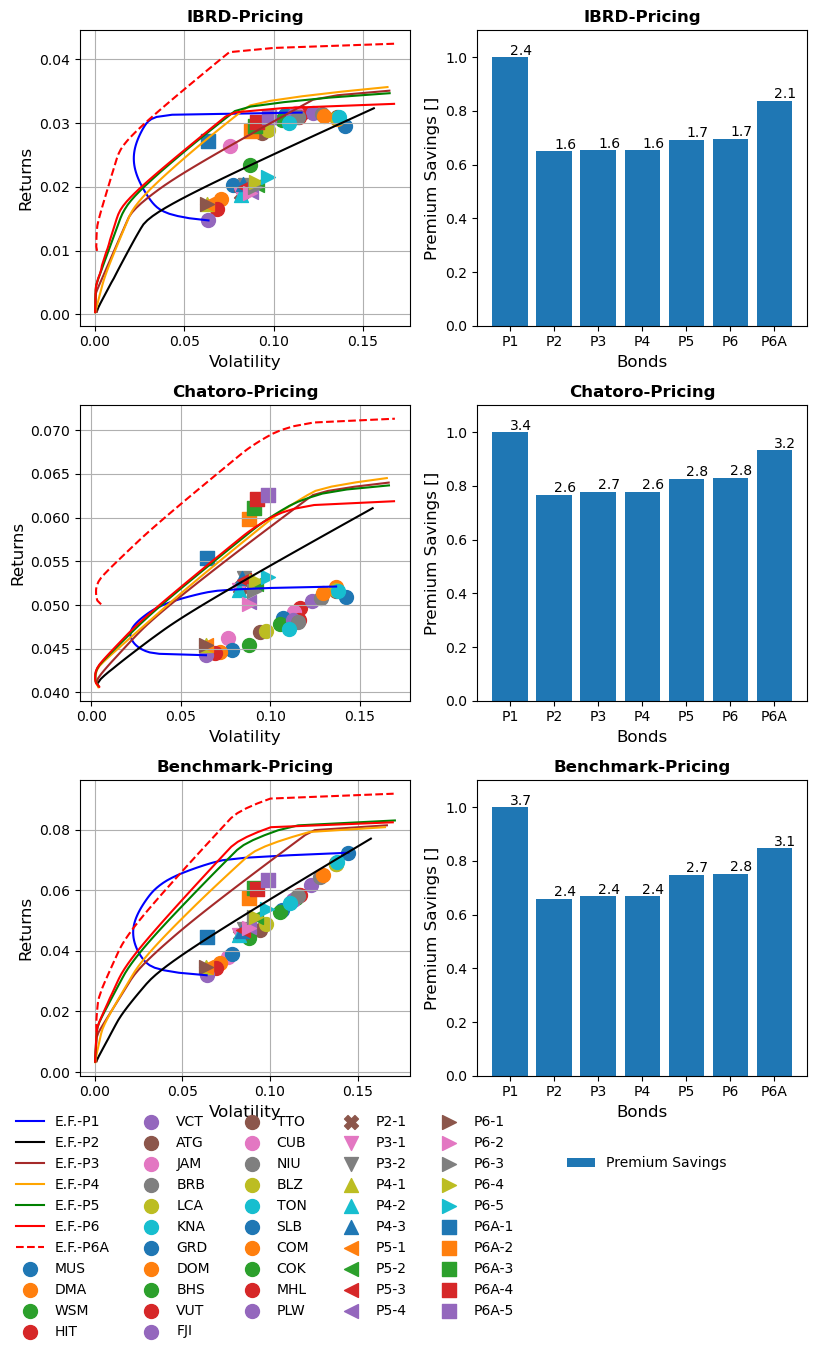

In [7]:
premiums_abs_keys = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P6A']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd', 'regression' ,'required'] #'artemis'
premium_methods_title = ['IBRD-Pricing', 'Chatoro-Pricing', 'Benchmark-Pricing'] #'Artemis-Pricing'
num_plots = len(premium_methods)
fig, axes = plt.subplots(num_plots, 2, figsize=(8.27, 4 * num_plots))  # 2.99

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s1 = {}
    premiums_pool_s2 = {}
    premiums_pool_s3 = {}
    premiums_pool_s4 = {}
    premiums_pool_s5 = {}
    premiums_pool_s5_a = {}
    for pool, prem_modes in premiums_s1.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s1:  # If the key already exists, sum the values
                    premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
    for pool, prem_modes in premiums_s3.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s3:  # If the key already exists, sum the values
                    premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
    for pool, prem_modes in premiums_s4.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s4:  # If the key already exists, sum the values
                    premiums_pool_s4[key] += np.sum(values * nominal_s4[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s4[key] = np.sum(values * nominal_s4[pool])
    for pool, prem_modes in premiums_s5.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5:  # If the key already exists, sum the values
                    premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
    for pool, prem_modes in premiums_s5_a.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a:  # If the key already exists, sum the values
                    premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_ibrd
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_ibrd
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_ibrd
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_ibrd
        s1_ann_ret = s1_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        s3_ann_ret = s3_ann_ret_ibrd
        s4_ann_ret = s4_ann_ret_ibrd
        s5_ann_ret = s5_ann_ret_ibrd
        s5_a_ann_ret = s5_a_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_regr
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_regr
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_regr
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_regr
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_regr
        s1_ann_ret = s1_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        s3_ann_ret = s3_ann_ret_regr
        s4_ann_ret = s4_ann_ret_regr
        s5_ann_ret = s5_ann_ret_regr
        s5_a_ann_ret = s5_a_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])

    elif prem_mode == 'artemis':
        sng_ann_ret = sng_ann_ret_artemis
        sng_ann_ret_df = sng_ann_ret_df_artemis
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_arte
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_arte
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_arte
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_arte
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_arte
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_arte
        s1_ann_ret = s1_ann_ret_arte
        s2_ann_ret = s2_ann_ret_arte
        s3_ann_ret = s3_ann_ret_arte
        s4_ann_ret = s4_ann_ret_arte
        s5_ann_ret = s5_ann_ret_arte
        s5_a_ann_ret = s5_a_ann_ret_arte
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][3])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][3])

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_requ
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_requ
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_requ
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_requ
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_requ
        s1_ann_ret = s1_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        s3_ann_ret = s3_ann_ret_requ
        s4_ann_ret = s4_ann_ret_requ
        s5_ann_ret = s5_ann_ret_requ
        s5_a_ann_ret = s5_a_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
    else:
        print('Wrong input premium mode')
        continue

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s1 = pd.DataFrame({f"{country} Returns": returns for country, returns in s1_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s3 = pd.DataFrame({f"{country} Returns": returns for country, returns in s3_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s4 = pd.DataFrame({f"{country} Returns": returns for country, returns in s4_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5 = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_tranches_ann_ret_df.items()}).dropna(axis=1)

    r = np.mean(df_returns,axis=0)
    r_s1= np.mean(df_returns_s1,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)
    r_s3= np.mean(df_returns_s3,axis=0)
    r_s4= np.mean(df_returns_s4,axis=0)
    r_s5= np.mean(df_returns_s5,axis=0)
    r_s5_a= np.mean(df_returns_s5_a,axis=0)

    # Create a covariance matrix
    covar = df_returns.cov()
    covar_s1 = df_returns_s1.cov()
    covar_s2 = df_returns_s2.cov()
    covar_s3 = df_returns_s3.cov()
    covar_s4 = df_returns_s4.cov()
    covar_s5 = df_returns_s5.cov()
    covar_s5_a = df_returns_s5_a.cov()

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_assets = len(df_returns.columns)

    p_ret_s1 = [] # Define an empty array for portfolio returns
    p_vol_s1 = [] # Define an empty array for portfolio volatility
    p_weights_s1 = [] # Define an empty array for asset weights

    num_assets_s1 = len(df_returns_s1.columns)

    p_ret_s2 = [] # Define an empty array for portfolio returns
    p_vol_s2 = [] # Define an empty array for portfolio volatility
    p_weights_s2 = [] # Define an empty array for asset weights

    num_assets_s2 = len(df_returns_s2.columns)

    p_ret_s3 = [] # Define an empty array for portfolio returns
    p_vol_s3 = [] # Define an empty array for portfolio volatility
    p_weights_s3 = [] # Define an empty array for asset weights

    num_assets_s3 = len(df_returns_s3.columns)

    p_ret_s4 = [] # Define an empty array for portfolio returns
    p_vol_s4 = [] # Define an empty array for portfolio volatility
    p_weights_s4 = [] # Define an empty array for asset weights

    num_assets_s4 = len(df_returns_s4.columns)

    p_ret_s5 = [] # Define an empty array for portfolio returns
    p_vol_s5 = [] # Define an empty array for portfolio volatility
    p_weights_s5 = [] # Define an empty array for asset weights

    num_assets_s5 = len(df_returns_s5.columns)

    p_ret_s5_a = [] # Define an empty array for portfolio returns
    p_vol_s5_a = [] # Define an empty array for portfolio volatility
    p_weights_s5_a = [] # Define an empty array for asset weights

    num_assets_s5_a = len(df_returns_s5_a.columns)

    num_portfolios = 10000  # Number of portfolios to simulate
    alpha_port = 0.3


    for _ in range(num_portfolios):
        weights = dirichlet([alpha_port] * num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, r) 
        p_ret.append(returns)
        var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # yearly standard deviation
        p_vol.append(sd)    

        weights_s1 = dirichlet([alpha_port] * num_assets_s1)
        weights_s1 = weights_s1/np.sum(weights_s1)
        p_weights_s1.append(weights_s1)
        returns_s1 = np.dot(weights_s1, r_s1) 
        p_ret_s1.append(returns_s1)
        var_s1= covar_s1.mul(weights_s1, axis=0).mul(weights_s1, axis=1).sum().sum()# Portfolio Variance
        sd_s1 = np.sqrt(var_s1) # yearly standard deviation
        p_vol_s1.append(sd_s1)

        weights_s2 = dirichlet([alpha_port] * num_assets_s2)
        weights_s2 = weights_s2/np.sum(weights_s2)
        p_weights_s2.append(weights_s2)
        returns_s2 = np.dot(weights_s2, r_s2) 
        p_ret_s2.append(returns_s2)
        var_s2= covar_s2.mul(weights_s2, axis=0).mul(weights_s2, axis=1).sum().sum()# Portfolio Variance
        sd_s2 = np.sqrt(var_s2) # yearly standard deviation
        p_vol_s2.append(sd_s2)

        weights_s3 = dirichlet([alpha_port] * num_assets_s3)
        weights_s3 = weights_s3/np.sum(weights_s3)
        p_weights_s3.append(weights_s3)
        returns_s3 = np.dot(weights_s3, r_s3) 
        p_ret_s3.append(returns_s3)
        var_s3= covar_s3.mul(weights_s3, axis=0).mul(weights_s3, axis=1).sum().sum()# Portfolio Variance
        sd_s3 = np.sqrt(var_s3) # yearly standard deviation
        p_vol_s3.append(sd_s3)

        weights_s4 = dirichlet([alpha_port] * num_assets_s4)
        weights_s4 = weights_s4/np.sum(weights_s4)
        p_weights_s4.append(weights_s4)
        returns_s4 = np.dot(weights_s4, r_s4) 
        p_ret_s4.append(returns_s4)
        var_s4= covar_s4.mul(weights_s4, axis=0).mul(weights_s4, axis=1).sum().sum()# Portfolio Variance
        sd_s4 = np.sqrt(var_s4) # yearly standard deviation
        p_vol_s4.append(sd_s4)

        weights_s5 = dirichlet([alpha_port] * num_assets_s5)
        weights_s5 = weights_s5/np.sum(weights_s5)
        p_weights_s5.append(weights_s5)
        returns_s5 = np.dot(weights_s5, r_s5) 
        p_ret_s5.append(returns_s5)
        var_s5= covar_s5.mul(weights_s5, axis=0).mul(weights_s5, axis=1).sum().sum()# Portfolio Variance
        sd_s5 = np.sqrt(var_s5) # yearly standard deviation
        p_vol_s5.append(sd_s5)

        weights_s5_a = dirichlet([alpha_port] * num_assets_s5_a)
        weights_s5_a = weights_s5_a/np.sum(weights_s5_a)
        p_weights_s5_a.append(weights_s5_a)
        returns_s5_a = np.dot(weights_s5_a, r_s5_a) 
        p_ret_s5_a.append(returns_s5_a)
        var_s5_a = covar_s5_a.mul(weights_s5_a, axis=0).mul(weights_s5_a, axis=1).sum().sum()# Portfolio Variance
        sd_s5_a = np.sqrt(var_s5_a) # yearly standard deviation
        p_vol_s5_a.append(sd_s5_a)

    data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}
    data_s1 = {'Returns':p_ret_s1, 'Volatility':p_vol_s1, 'Sharpe Ratio':np.array(p_ret_s1)/np.array(p_vol_s1)}
    data_s2 = {'Returns':p_ret_s2, 'Volatility':p_vol_s2, 'Sharpe Ratio':np.array(p_ret_s2)/np.array(p_vol_s2)}
    data_s3 = {'Returns':p_ret_s3, 'Volatility':p_vol_s3, 'Sharpe Ratio':np.array(p_ret_s3)/np.array(p_vol_s3)}
    data_s4 = {'Returns':p_ret_s4, 'Volatility':p_vol_s4, 'Sharpe Ratio':np.array(p_ret_s4)/np.array(p_vol_s4)}
    data_s5 = {'Returns':p_ret_s5, 'Volatility':p_vol_s5, 'Sharpe Ratio':np.array(p_ret_s5)/np.array(p_vol_s5)}
    data_s5_a = {'Returns':p_ret_s5_a, 'Volatility':p_vol_s5_a, 'Sharpe Ratio':np.array(p_ret_s5_a)/np.array(p_vol_s5_a)}

    for counter, symbol in enumerate(df_returns.columns.tolist()):
        data[str(symbol)+' weight'] = [w[counter] for w in p_weights]

    for counter, symbol in enumerate(df_returns_s1.columns.tolist()):
        data_s1[str(symbol)+' weight'] = [w[counter] for w in p_weights_s1]

    for counter, symbol in enumerate(df_returns_s2.columns.tolist()):
        data_s2[str(symbol)+' weight'] = [w[counter] for w in p_weights_s2]
        
    for counter, symbol in enumerate(df_returns_s3.columns.tolist()):
        data_s3[str(symbol)+' weight'] = [w[counter] for w in p_weights_s3]

    for counter, symbol in enumerate(df_returns_s4.columns.tolist()):
        data_s4[str(symbol)+' weight'] = [w[counter] for w in p_weights_s4]

    for counter, symbol in enumerate(df_returns_s5.columns.tolist()):
        data_s5[str(symbol)+' weight'] = [w[counter] for w in p_weights_s5]

    for counter, symbol in enumerate(df_returns_s5_a.columns.tolist()):
        data_s5_a[str(symbol)+' weight'] = [w[counter] for w in p_weights_s5_a]

    portfolios  = pd.DataFrame(data)
    portfolios_s1 = pd.DataFrame(data_s1)
    portfolios_s2 = pd.DataFrame(data_s2)
    portfolios_s3 = pd.DataFrame(data_s3)
    portfolios_s4 = pd.DataFrame(data_s4)
    portfolios_s5 = pd.DataFrame(data_s5)
    portfolios_s5_a = pd.DataFrame(data_s5_a)
    portfolios_tot = pd.concat([portfolios, portfolios_s1, portfolios_s2, portfolios_s3, portfolios_s4, portfolios_s5, portfolios_s5_a], axis=0)

    # Function to calculate portfolio risk (standard deviation)
    def portfolio_risk(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Function to calculate portfolio return
    def portfolio_return(weights, mean_returns):
        return np.sum(weights * mean_returns)

    # Function for optimization: minimize risk for a given return
    def minimize_risk(target_return, mean_returns, cov_matrix):
        # Number of assets in the portfolio
        num_assets = len(mean_returns)

        # Constraints: weights sum to 1, and portfolio return equals target return
        constraints = ({
            'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
        }, {
            'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
        })

        # Initial guess: equal weights
        initial_guess = np.ones(num_assets) / num_assets

        # Bounds for weights: between 0 and 1
        bounds = tuple((0, 1) for asset in range(num_assets))

        # Minimize risk (objective function)
        result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

        return result.x, result.fun  # Return the optimized weights and the minimized risk

    # Generate a series of target returns and corresponding risks
    target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    ## Repeat for the second data set (df_returns_pool)
    risks_s1 = []
    target_returns_s1 = np.linspace(np.min(r_s1), np.max(r_s1), 50)
    for target_return in target_returns_s1:
        weights, risk = minimize_risk(target_return, r_s1, covar_s1)
        risks_s1.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    risks_s3 = []
    target_returns_s3 = np.linspace(np.min(r_s3), np.max(r_s3), 50)
    for target_return in target_returns_s3:
        weights, risk = minimize_risk(target_return, r_s3, covar_s3)
        risks_s3.append(risk)

    risks_s4 = []
    target_returns_s4 = np.linspace(np.min(r_s4), np.max(r_s4), 50)
    for target_return in target_returns_s4:
        weights, risk = minimize_risk(target_return, r_s4, covar_s4)
        risks_s4.append(risk)

    risks_s5 = []
    target_returns_s5 = np.linspace(np.min(r_s5), np.max(r_s5), 50)
    for target_return in target_returns_s5:
        weights, risk = minimize_risk(target_return, r_s5, covar_s5)
        risks_s5.append(risk)

    risks_s5_a = []
    target_returns_s5_a = np.linspace(np.min(r_s5_a), np.max(r_s5_a), 50)
    for target_return in target_returns_s5_a:
        weights, risk = minimize_risk(target_return, r_s5_a, covar_s5_a)
        risks_s5_a.append(risk)

    #scatter = axes[j, 0].scatter(
    #    x=portfolios_tot['Volatility'], 
    #    y=portfolios_tot['Returns'], 
    #    #c=portfolios_tot['Sharpe Ratio'], 
    #    #cmap='viridis', 
    #    marker='o', 
    #    s=10, 
    #    alpha=0.1
    #    #vmin=0.1,  
    #    #vmax=3.0
    #)    
    #cbar = plt.colorbar(scatter)
    #cbar.set_label('Sharpe Ratio', fontsize=12)
    axes[j, 0].plot(risks, target_returns, label="E.F.-P1", color='blue')
    axes[j, 0].plot(risks_s1, target_returns_s1, label="E.F.-P2", color='black')
    axes[j, 0].plot(risks_s2, target_returns_s2, label="E.F.-P3", color='brown')
    axes[j, 0].plot(risks_s3, target_returns_s3, label="E.F.-P4", color='orange')
    axes[j, 0].plot(risks_s4, target_returns_s4, label="E.F.-P5", color='green')
    axes[j, 0].plot(risks_s5, target_returns_s5, label="E.F.-P6", color='red')
    axes[j, 0].plot(risks_s5_a, target_returns_s5_a, label="E.F.-P6A", color='red', linestyle='--')

    for i, cty in enumerate(countries):
        axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)]), np.mean(sng_ann_ret[str(cty)]), label=countries_str[i], s=100)
    for pool in s1_ann_ret:
        axes[j, 0].scatter(np.std(s1_ann_ret[pool]), np.mean(s1_ann_ret[pool]), label=f'P2-{pool}', marker='X', s=100)
    for pool in s2_ann_ret:
        axes[j, 0].scatter(np.std(s2_ann_ret[pool]), np.mean(s2_ann_ret[pool]), label=f'P3-{pool}', marker='v', s=100)
    for pool in s3_ann_ret:
        axes[j, 0].scatter(np.std(s3_ann_ret[pool]), np.mean(s3_ann_ret[pool]), label=f'P4-{pool}', marker='^', s=100)
    for pool in s4_ann_ret:
        axes[j, 0].scatter(np.std(s4_ann_ret[pool]), np.mean(s4_ann_ret[pool]), label=f'P5-{pool}', marker='<', s=100)
    for pool in s5_ann_ret:
        axes[j, 0].scatter(np.std(s5_ann_ret[pool]), np.mean(s5_ann_ret[pool]), label=f'P6-{pool}', marker='>', s=100)
    for pool in s5_a_ann_ret:
        axes[j, 0].scatter(np.std(s5_a_ann_ret[pool]), np.mean(s5_a_ann_ret[pool]), label=f'P6A-{pool}', marker='s', s=100)
    axes[j, 0].set_xlabel("Volatility", fontsize=12)
    axes[j, 0].set_ylabel("Returns", fontsize=12)
    axes[j, 0].grid(True)
    axes[j, 0].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')


    x_labels = ["P1", "P2", "P3", "P4", "P5", "P6", "P6A"]
    s = sng_cty_premium
    prem_diff = [np.sum(s)/np.sum(s), 
                 np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                 np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                 np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                 np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                 np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                 np.sum(premiums_pool_s5_a['Total_alt'])/np.sum(s)]

    tot_pay_s1 = 0
    tot_pay_s2 = 0
    tot_pay_s3 = 0
    tot_pay_s4 = 0
    tot_pay_s5 = 0
    tot_pay_s5_a = 0
    for pool in es_metrics_s1:
        tot_pay_s1 += es_metrics_s1[pool]['Payout']
    for pool in es_metrics_s2:
        tot_pay_s2 += es_metrics_s2[pool]['Payout']
    for pool in es_metrics_s3:
        tot_pay_s3 += es_metrics_s3[pool]['Payout']
    for pool in es_metrics_s4:
        tot_pay_s4 += es_metrics_s4[pool]['Payout']
    for pool in es_metrics_s5:
        tot_pay_s5 += es_metrics_s5[pool]['Payout']
    for pool in es_metrics_s5_a:
        tot_pay_s5_a += es_metrics_s5_a[pool]['Payout']


    im = [np.sum(s)/np.sum(sng_cty_pay), 
          np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
          np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s2,
          np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s3,
          np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s4,
          np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s5,
          np.sum(premiums_pool_s5_a['Total_alt'])/tot_pay_s5_a]

    for q in range(len(im)):
        axes[j, 1].text(x_labels[q], prem_diff[q]+0.01, round(im[q],1))
    axes[j, 1].bar(x_labels, prem_diff, label='Premium Savings')
    axes[j, 1].set_xlabel("Bonds", fontsize=12)
    axes[j, 1].set_ylabel("Premium Savings []", fontsize=12)
    axes[j, 1].set_ylim(0, 1.1)
    axes[j, 1].tick_params(axis='y')
    axes[j, 1].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')
    
    premiums_abs['P1'][prem_mode] = np.sum(sng_cty_premium)/len(sng_ann_ret['212'])
    premiums_abs['P2'][prem_mode] = premiums_pool_s1['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P3'][prem_mode] = premiums_pool_s2['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P4'][prem_mode] = premiums_pool_s3['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P5'][prem_mode] = premiums_pool_s4['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P6'][prem_mode] = premiums_pool_s5['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a['Total_alt']/len(sng_ann_ret['212'])

    print(f"Sng Premiums {prem_mode}: {premiums_abs['P1'][prem_mode]}; {prem_diff[0]}")
    print(f"P2 Premiums {prem_mode}: {premiums_abs['P2'][prem_mode]}; {prem_diff[1]}")
    print(f"P3 Premiums {prem_mode}: {premiums_abs['P3'][prem_mode]}; {prem_diff[2]}")
    print(f"P4 Premiums {prem_mode}: {premiums_abs['P4'][prem_mode]}; {prem_diff[3]}")
    print(f"P5 Premiums {prem_mode}: {premiums_abs['P5'][prem_mode]}; {prem_diff[4]}")
    print(f"P6 Premiums {prem_mode}: {premiums_abs['P6'][prem_mode]}; {prem_diff[5]}")
    print(f"P6A Premiums {prem_mode}: {premiums_abs['P6A'][prem_mode]}; {prem_diff[6]}")
nominal_sng = 0
for key in nominal_sng_dic:
    nominal_sng += nominal_sng_dic[key]
print(f"Sng Nominal: {nominal_sng}")
print(f"P2 Nominal: {nominal_s1['1']}; {nominal_s1['1']/nominal_sng}")
nominal_pool_s2 = 0
for key in nominal_s2:
    nominal_pool_s2 += nominal_s2[key]
print(f"P3 Nominal: {nominal_pool_s2}; {nominal_pool_s2/nominal_sng}")
nominal_pool_s3 = 0
for key in nominal_s3:
    nominal_pool_s3 += nominal_s3[key]
print(f"P4 Nominal: {nominal_pool_s3}; {nominal_pool_s3/nominal_sng}")
nominal_pool_s4 = 0
for key in nominal_s4:
    nominal_pool_s4 += nominal_s4[key]
print(f"P5 Nominal: {nominal_pool_s4}; {nominal_pool_s4/nominal_sng}")
nominal_pool_s5 = 0
for key in nominal_s5:
    nominal_pool_s5 += nominal_s5[key]
print(f"P6 Nominal: {nominal_pool_s5}; {nominal_pool_s5/nominal_sng}")
nominal_pool_s5_a = 0
for key in nominal_s5_a:
    nominal_pool_s5_a += nominal_s5_a[key]
print(f"P6 Nominal: {nominal_pool_s5_a}; {nominal_pool_s5_a/nominal_sng}")



handles0, labels0 = axes[j, 0].get_legend_handles_labels()
fig.legend(
    handles0,
    labels0,
    loc='lower left',
    bbox_to_anchor=(0.01, -0.13),
    ncol=5,
    frameon=False,
)

handles1, labels1 = axes[j, 1].get_legend_handles_labels()  
fig.legend(
    handles1,
    labels1,
    loc='lower right',
    bbox_to_anchor=(0.90, 0.01),
    ncol=1,
    frameon=False
)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [8]:
prem_mode = 'ibrd'
premiums_pool_s1 = {}
premiums_pool_s2 = {}
premiums_pool_s3 = {}
premiums_pool_s4 = {}
premiums_pool_s5 = {}
premiums_pool_s5_a = {}
for pool, prem_modes in premiums_s1.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s1:  # If the key already exists, sum the values
                premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
for pool, prem_modes in premiums_s2.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s2:  # If the key already exists, sum the values
                premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
for pool, prem_modes in premiums_s3.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s3:  # If the key already exists, sum the values
                premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
for pool, prem_modes in premiums_s4.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s4:  # If the key already exists, sum the values
                premiums_pool_s4[key] += np.sum(values * nominal_s4[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s4[key] = np.sum(values * nominal_s4[pool])
for pool, prem_modes in premiums_s5.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s5:  # If the key already exists, sum the values
                premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
for pool, prem_modes in premiums_s5_a.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s5_a:  # If the key already exists, sum the values
                premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])

sng_cty_premium = []
sng_cty_pay = []
for cty in bond_metrics_sng_dic:
    sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
    sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])

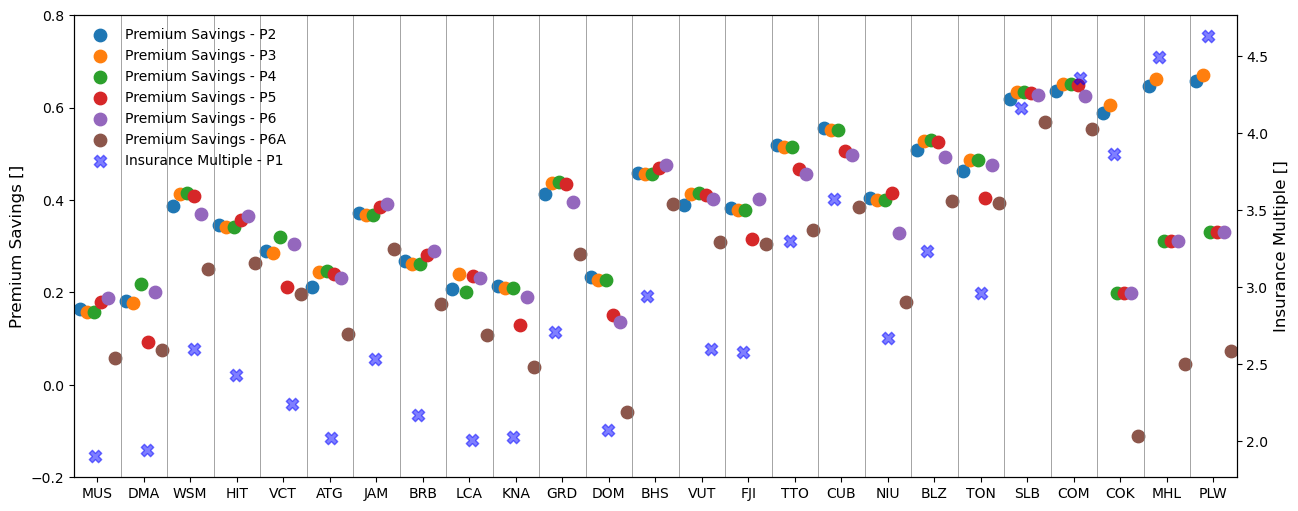

In [9]:
s = {'P1': None, 'P2': [], 'P3': [], 'P4': [], 'P5': [], 'P6': [], 'P6A': []}
n = []
s['P1'] = sng_cty_premium

for cty in countries:
    s['P2'].append(np.sum(premiums_pool_s1[cty]))
    s['P3'].append(np.sum(premiums_pool_s2[cty]))
    s['P4'].append(np.sum(premiums_pool_s3[cty]))
    s['P5'].append(np.sum(premiums_pool_s4[cty]))
    s['P6'].append(np.sum(premiums_pool_s5[cty]))
    s['P6A'].append(np.sum(premiums_pool_s5_a[cty]))

prem_diff = {}
for key in s:
    prem_diff[key] = (1-(np.array(s[key])/np.array(s['P1']))).tolist()

im = (np.array(sng_cty_premium)/np.array(sng_cty_pay)).tolist()

def jitter(x):
    return x + random.uniform(-0.2, .2)

type_ids = {}
type_ids_ls = []
for i, cty in enumerate(countries_str):
    type_ids[cty] = i
    type_ids_ls.append(i)

jitter_type_im = [jitter(type_ids[cty]) for cty in countries_str]
jitter_type_ps = [jitter(type_ids[cty]) for cty in countries_str]

fig, ax = plt.subplots(figsize=(15,6))  # Correct the typo

iterator = -0.375
for key in prem_diff:
    if key != 'P1':
        ax.scatter(np.array(type_ids_ls)+iterator, prem_diff[key], label=f'Premium Savings - {key}', s=80)
        iterator += 0.1525
ax.set_ylabel("Premium Savings []", fontsize=12)
ax.tick_params(axis='y')
ax.set_ylim(-0.2,0.8)


# Vertical lines at specified positions
x_positions = np.arange(0.5, len(countries_str) - 1 + 0.6).tolist()
for x in x_positions:
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=0.5)

# Secondary y-axis for Premium Savings
ax2 = ax.twinx()
# Scatter plot for Insurance Multiple
ax2.scatter(jitter_type_im, im, color='blue', label='Insurance Multiple - P1', marker='X', s=80, alpha=0.5)
ax2.set_xlabel("Bonds", fontsize=12)
ax2.set_ylabel("Insurance Multiple []", fontsize=12)
ax2.tick_params(axis='y')

# X-axis limits and labels
ax.set_xlim(-0.5, len(countries_str) - 0.5)
ax.set_xticks(np.arange(0, len(countries_str)).tolist())
ax.set_xticklabels(list(type_ids.keys()))

handles1, labels1 = ax.get_legend_handles_labels()  
handles2, labels2 = ax2.get_legend_handles_labels() 
plt.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper left',
    #bbox_to_anchor=(0.85, 0.03),
    ncol=1,
    frameon=False
)
plt.show()


In [10]:
s

{'P1': [10877002214075.64,
  360270961290.6274,
  479412921525.662,
  8306359397144.54,
  525882750406.59436,
  916808468180.9802,
  7602376059098.083,
  2908874585084.2627,
  939594950233.6674,
  552153527179.0063,
  521999279855.5237,
  44817184993711.95,
  4080882576039.6436,
  387690627261.0606,
  1734379598939.7676,
  6497888873649.228,
  29106181119469.664,
  3602228263.780862,
  567058692668.905,
  116380399160.45953,
  177558497776.38464,
  109555427067.50784,
  27079349678.867916,
  11293313615.467953,
  8940022613.593157],
 'P2': [9093156590299.354,
  294501951634.5753,
  293361654410.65607,
  5432306101022.762,
  373425621415.4633,
  721883587760.218,
  4766724141477.786,
  2130334733745.6877,
  744451510759.9504,
  433693979197.8064,
  305866343486.7534,
  34348328363694.82,
  2205238269001.5693,
  236842308807.49054,
  1069589041083.1226,
  3127686535765.0635,
  12941111067218.646,
  2142172739.0294955,
  278724659811.92267,
  62394587191.74865,
  67762307920.411575,
  399

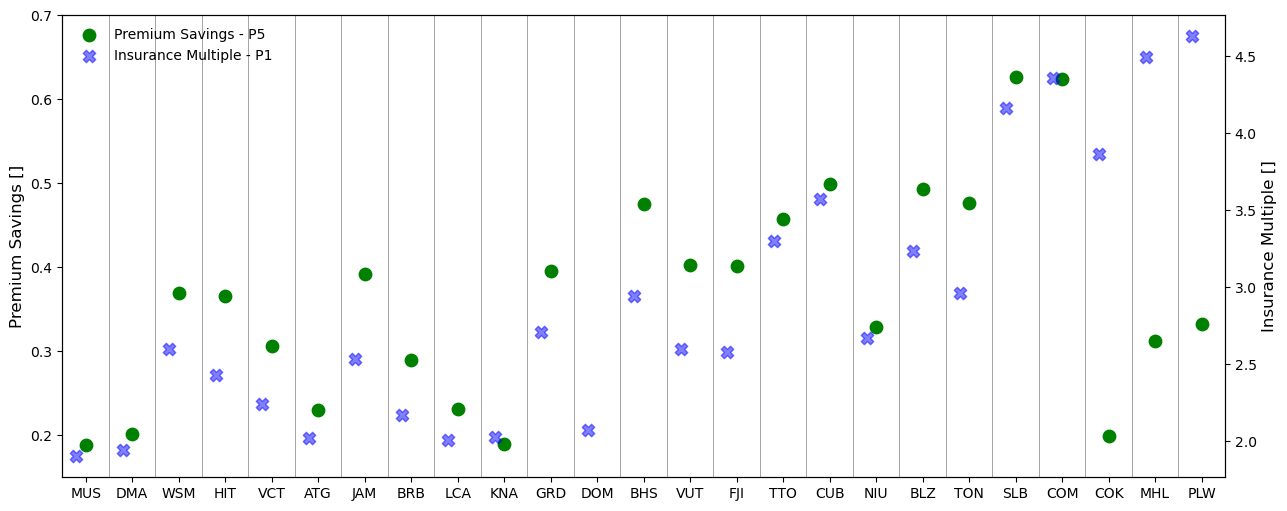

In [11]:
s = {'P1': None, 'P5': []}
n = []
s['P1'] = sng_cty_premium

for cty in countries:
    s['P5'].append(np.sum(premiums_pool_s5[cty]))

prem_diff = {}
for key in s:
    prem_diff[key] = (1-(np.array(s[key])/np.array(s['P1']))).tolist()

im = (np.array(sng_cty_premium)/np.array(sng_cty_pay)).tolist()

def jitter(x):
    return x + random.uniform(-0.2, .2)

type_ids = {}
type_ids_ls = []
for i, cty in enumerate(countries_str):
    type_ids[cty] = i
    type_ids_ls.append(i)

jitter_type_im = [jitter(type_ids[cty]) for cty in countries_str]
jitter_type_ps = [jitter(type_ids[cty]) for cty in countries_str]

fig, ax = plt.subplots(figsize=(15,6))  # Correct the typo

iterator = -0
for key in prem_diff:
    if key != 'P1':
        ax.scatter(np.array(type_ids_ls)+iterator, prem_diff[key], color='green', label=f'Premium Savings - {key}', s=80)
        iterator += 0.2
ax.set_ylabel("Premium Savings []", fontsize=12)
ax.tick_params(axis='y')
ax.set_ylim(0.15,0.7)


# Vertical lines at specified positions
x_positions = np.arange(0.5, len(countries_str) - 1 + 0.6).tolist()
for x in x_positions:
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=0.5)

# Secondary y-axis for Premium Savings
ax2 = ax.twinx()
# Scatter plot for Insurance Multiple
ax2.scatter(np.array(type_ids_ls)-0.2, im, color='blue', label='Insurance Multiple - P1', marker='X', s=80, alpha=0.5)
ax2.set_xlabel("Bonds", fontsize=12)
ax2.set_ylabel("Insurance Multiple []", fontsize=12)
ax2.tick_params(axis='y')

# X-axis limits and labels
ax.set_xlim(-0.5, len(countries_str) - 0.5)
ax.set_xticks(np.arange(0, len(countries_str)).tolist())
ax.set_xticklabels(list(type_ids.keys()))

handles1, labels1 = ax.get_legend_handles_labels()  
handles2, labels2 = ax2.get_legend_handles_labels() 
plt.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper left',
    #bbox_to_anchor=(0.85, 0.03),
    ncol=1,
    frameon=False
)
plt.show()


In [ ]:
premiums_abs_keys = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P6A']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['regression'] #'artemis'
premium_methods_title = ['Chatoro-Pricing'] #'Artemis-Pricing'
num_plots = len(premium_methods)
fig, axes = plt.subplots(num_plots, figsize=(8.27, 6 * num_plots))  # 2.99

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s1 = {}
    premiums_pool_s2 = {}
    premiums_pool_s3 = {}
    premiums_pool_s4 = {}
    premiums_pool_s5 = {}
    premiums_pool_s5_a = {}
    for pool, prem_modes in premiums_s1.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s1:  # If the key already exists, sum the values
                    premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
    for pool, prem_modes in premiums_s3.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s3:  # If the key already exists, sum the values
                    premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
    for pool, prem_modes in premiums_s4.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s4:  # If the key already exists, sum the values
                    premiums_pool_s4[key] += np.sum(values * nominal_s4[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s4[key] = np.sum(values * nominal_s4[pool])
    for pool, prem_modes in premiums_s5.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5:  # If the key already exists, sum the values
                    premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
    for pool, prem_modes in premiums_s5_a.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a:  # If the key already exists, sum the values
                    premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])
            
    if prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_regr
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_regr
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_regr
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_regr
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_regr
        s1_ann_ret = s1_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        s3_ann_ret = s3_ann_ret_regr
        s4_ann_ret = s4_ann_ret_regr
        s5_ann_ret = s5_ann_ret_regr
        s5_a_ann_ret = s5_a_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])


    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})[['882 Returns', '174 Returns']]
    df_returns_s1 = pd.DataFrame({f"{country} Returns": returns for country, returns in s1_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s3 = pd.DataFrame({f"{country} Returns": returns for country, returns in s3_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s4 = pd.DataFrame({f"{country} Returns": returns for country, returns in s4_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5 = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_tranches_ann_ret_df.items()}).dropna(axis=1)

    r = np.mean(df_returns,axis=0)
    r_s1= np.mean(df_returns_s1,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)
    r_s3= np.mean(df_returns_s3,axis=0)
    r_s4= np.mean(df_returns_s4,axis=0)
    r_s5= np.mean(df_returns_s5,axis=0)
    r_s5_a= np.mean(df_returns_s5_a,axis=0)

    # Create a covariance matrix
    covar = df_returns.cov()
    covar_s1 = df_returns_s1.cov()
    covar_s2 = df_returns_s2.cov()
    covar_s3 = df_returns_s3.cov()
    covar_s4 = df_returns_s4.cov()
    covar_s5 = df_returns_s5.cov()
    covar_s5_a = df_returns_s5_a.cov()

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_assets = len(df_returns.columns)

    p_ret_s1 = [] # Define an empty array for portfolio returns
    p_vol_s1 = [] # Define an empty array for portfolio volatility
    p_weights_s1 = [] # Define an empty array for asset weights

    num_assets_s1 = len(df_returns_s1.columns)

    p_ret_s2 = [] # Define an empty array for portfolio returns
    p_vol_s2 = [] # Define an empty array for portfolio volatility
    p_weights_s2 = [] # Define an empty array for asset weights

    num_assets_s2 = len(df_returns_s2.columns)

    p_ret_s3 = [] # Define an empty array for portfolio returns
    p_vol_s3 = [] # Define an empty array for portfolio volatility
    p_weights_s3 = [] # Define an empty array for asset weights

    num_assets_s3 = len(df_returns_s3.columns)

    p_ret_s4 = [] # Define an empty array for portfolio returns
    p_vol_s4 = [] # Define an empty array for portfolio volatility
    p_weights_s4 = [] # Define an empty array for asset weights

    num_assets_s4 = len(df_returns_s4.columns)

    p_ret_s5 = [] # Define an empty array for portfolio returns
    p_vol_s5 = [] # Define an empty array for portfolio volatility
    p_weights_s5 = [] # Define an empty array for asset weights

    num_assets_s5 = len(df_returns_s5.columns)

    p_ret_s5_a = [] # Define an empty array for portfolio returns
    p_vol_s5_a = [] # Define an empty array for portfolio volatility
    p_weights_s5_a = [] # Define an empty array for asset weights

    num_assets_s5_a = len(df_returns_s5_a.columns)

    num_portfolios = 10000  # Number of portfolios to simulate
    alpha_port = 0.1


    for _ in range(num_portfolios):
        weights = dirichlet([alpha_port] * num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, r) 
        p_ret.append(returns)
        var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # yearly standard deviation
        p_vol.append(sd)    

        weights_s1 = dirichlet([alpha_port] * num_assets_s1)
        weights_s1 = weights_s1/np.sum(weights_s1)
        p_weights_s1.append(weights_s1)
        returns_s1 = np.dot(weights_s1, r_s1) 
        p_ret_s1.append(returns_s1)
        var_s1= covar_s1.mul(weights_s1, axis=0).mul(weights_s1, axis=1).sum().sum()# Portfolio Variance
        sd_s1 = np.sqrt(var_s1) # yearly standard deviation
        p_vol_s1.append(sd_s1)

        weights_s2 = dirichlet([alpha_port] * num_assets_s2)
        weights_s2 = weights_s2/np.sum(weights_s2)
        p_weights_s2.append(weights_s2)
        returns_s2 = np.dot(weights_s2, r_s2) 
        p_ret_s2.append(returns_s2)
        var_s2= covar_s2.mul(weights_s2, axis=0).mul(weights_s2, axis=1).sum().sum()# Portfolio Variance
        sd_s2 = np.sqrt(var_s2) # yearly standard deviation
        p_vol_s2.append(sd_s2)

        weights_s3 = dirichlet([alpha_port] * num_assets_s3)
        weights_s3 = weights_s3/np.sum(weights_s3)
        p_weights_s3.append(weights_s3)
        returns_s3 = np.dot(weights_s3, r_s3) 
        p_ret_s3.append(returns_s3)
        var_s3= covar_s3.mul(weights_s3, axis=0).mul(weights_s3, axis=1).sum().sum()# Portfolio Variance
        sd_s3 = np.sqrt(var_s3) # yearly standard deviation
        p_vol_s3.append(sd_s3)

        weights_s4 = dirichlet([alpha_port] * num_assets_s4)
        weights_s4 = weights_s4/np.sum(weights_s4)
        p_weights_s4.append(weights_s4)
        returns_s4 = np.dot(weights_s4, r_s4) 
        p_ret_s4.append(returns_s4)
        var_s4= covar_s4.mul(weights_s4, axis=0).mul(weights_s4, axis=1).sum().sum()# Portfolio Variance
        sd_s4 = np.sqrt(var_s4) # yearly standard deviation
        p_vol_s4.append(sd_s4)

        weights_s5 = dirichlet([alpha_port] * num_assets_s5)
        weights_s5 = weights_s5/np.sum(weights_s5)
        p_weights_s5.append(weights_s5)
        returns_s5 = np.dot(weights_s5, r_s5) 
        p_ret_s5.append(returns_s5)
        var_s5= covar_s5.mul(weights_s5, axis=0).mul(weights_s5, axis=1).sum().sum()# Portfolio Variance
        sd_s5 = np.sqrt(var_s5) # yearly standard deviation
        p_vol_s5.append(sd_s5)

        weights_s5_a = dirichlet([alpha_port] * num_assets_s5_a)
        weights_s5_a = weights_s5_a/np.sum(weights_s5_a)
        p_weights_s5_a.append(weights_s5_a)
        returns_s5_a = np.dot(weights_s5_a, r_s5_a) 
        p_ret_s5_a.append(returns_s5_a)
        var_s5_a = covar_s5_a.mul(weights_s5_a, axis=0).mul(weights_s5_a, axis=1).sum().sum()# Portfolio Variance
        sd_s5_a = np.sqrt(var_s5_a) # yearly standard deviation
        p_vol_s5_a.append(sd_s5_a)

    data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}
    data_s1 = {'Returns':p_ret_s1, 'Volatility':p_vol_s1, 'Sharpe Ratio':np.array(p_ret_s1)/np.array(p_vol_s1)}
    data_s2 = {'Returns':p_ret_s2, 'Volatility':p_vol_s2, 'Sharpe Ratio':np.array(p_ret_s2)/np.array(p_vol_s2)}
    data_s3 = {'Returns':p_ret_s3, 'Volatility':p_vol_s3, 'Sharpe Ratio':np.array(p_ret_s3)/np.array(p_vol_s3)}
    data_s4 = {'Returns':p_ret_s4, 'Volatility':p_vol_s4, 'Sharpe Ratio':np.array(p_ret_s4)/np.array(p_vol_s4)}
    data_s5 = {'Returns':p_ret_s5, 'Volatility':p_vol_s5, 'Sharpe Ratio':np.array(p_ret_s5)/np.array(p_vol_s5)}
    data_s5_a = {'Returns':p_ret_s5_a, 'Volatility':p_vol_s5_a, 'Sharpe Ratio':np.array(p_ret_s5_a)/np.array(p_vol_s5_a)}

    for counter, symbol in enumerate(df_returns.columns.tolist()):
        data[str(symbol)+' weight'] = [w[counter] for w in p_weights]

    for counter, symbol in enumerate(df_returns_s1.columns.tolist()):
        data_s1[str(symbol)+' weight'] = [w[counter] for w in p_weights_s1]

    for counter, symbol in enumerate(df_returns_s2.columns.tolist()):
        data_s2[str(symbol)+' weight'] = [w[counter] for w in p_weights_s2]
        
    for counter, symbol in enumerate(df_returns_s3.columns.tolist()):
        data_s3[str(symbol)+' weight'] = [w[counter] for w in p_weights_s3]

    for counter, symbol in enumerate(df_returns_s4.columns.tolist()):
        data_s4[str(symbol)+' weight'] = [w[counter] for w in p_weights_s4]

    for counter, symbol in enumerate(df_returns_s5.columns.tolist()):
        data_s5[str(symbol)+' weight'] = [w[counter] for w in p_weights_s5]

    for counter, symbol in enumerate(df_returns_s5_a.columns.tolist()):
        data_s5_a[str(symbol)+' weight'] = [w[counter] for w in p_weights_s5_a]

    portfolios  = pd.DataFrame(data)
    portfolios_s1 = pd.DataFrame(data_s1)
    portfolios_s2 = pd.DataFrame(data_s2)
    portfolios_s3 = pd.DataFrame(data_s3)
    portfolios_s4 = pd.DataFrame(data_s4)
    portfolios_s5 = pd.DataFrame(data_s5)
    portfolios_s5_a = pd.DataFrame(data_s5_a)
    portfolios_tot = pd.concat([portfolios, portfolios_s1, portfolios_s2, portfolios_s3, portfolios_s4, portfolios_s5, portfolios_s5_a], axis=0)

    # Function to calculate portfolio risk (standard deviation)
    def portfolio_risk(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Function to calculate portfolio return
    def portfolio_return(weights, mean_returns):
        return np.sum(weights * mean_returns)

    # Function for optimization: minimize risk for a given return
    def minimize_risk(target_return, mean_returns, cov_matrix):
        # Number of assets in the portfolio
        num_assets = len(mean_returns)

        # Constraints: weights sum to 1, and portfolio return equals target return
        constraints = ({
            'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
        }, {
            'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
        })

        # Initial guess: equal weights
        initial_guess = np.ones(num_assets) / num_assets

        # Bounds for weights: between 0 and 1
        bounds = tuple((0, 1) for asset in range(num_assets))

        # Minimize risk (objective function)
        result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

        return result.x, result.fun  # Return the optimized weights and the minimized risk

    # Generate a series of target returns and corresponding risks
    target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    ## Repeat for the second data set (df_returns_pool)
    risks_s1 = []
    target_returns_s1 = np.linspace(np.min(r_s1), np.max(r_s1), 50)
    for target_return in target_returns_s1:
        weights, risk = minimize_risk(target_return, r_s1, covar_s1)
        risks_s1.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    risks_s3 = []
    target_returns_s3 = np.linspace(np.min(r_s3), np.max(r_s3), 50)
    for target_return in target_returns_s3:
        weights, risk = minimize_risk(target_return, r_s3, covar_s3)
        risks_s3.append(risk)

    risks_s4 = []
    target_returns_s4 = np.linspace(np.min(r_s4), np.max(r_s4), 50)
    for target_return in target_returns_s4:
        weights, risk = minimize_risk(target_return, r_s4, covar_s4)
        risks_s4.append(risk)

    risks_s5 = []
    target_returns_s5 = np.linspace(np.min(r_s5), np.max(r_s5), 50)
    for target_return in target_returns_s5:
        weights, risk = minimize_risk(target_return, r_s5, covar_s5)
        risks_s5.append(risk)

    risks_s5_a = []
    target_returns_s5_a = np.linspace(np.min(r_s5_a), np.max(r_s5_a), 50)
    for target_return in target_returns_s5_a:
        weights, risk = minimize_risk(target_return, r_s5_a, covar_s5_a)
        risks_s5_a.append(risk)

    scatter = axes.scatter(
        x=portfolios['Volatility'], 
        y=portfolios['Returns']*100, 
        #c=portfolios_tot['Sharpe Ratio'], 
        #cmap='viridis', 
        marker='o', 
        s=10, 
        alpha=0.3
        #vmin=0.1,  
        #vmax=3.0
    )    
    #cbar = plt.colorbar(scatter)
    #cbar.set_label('Sharpe Ratio', fontsize=12)
    #axes.plot(risks, target_returns, label="E.F.", color='blue')
    #axes.plot(risks_s1, target_returns_s1, label="E.F.-P1", color='black')
    #axes.plot(risks_s2, target_returns_s2, label="E.F.-P2", color='olive')
    #axes.plot(risks_s3, target_returns_s3, label="E.F.-P4", color='orange')
    #axes.plot(risks_s4, target_returns_s4, label="E.F.-P5", color='green')
    #axes.plot(risks_s5, target_returns_s5, label="E.F.-P5", color='red')
    #axes.plot(risks_s5_a, target_returns_s5_a, label="E.F.-P6A", color='red', linestyle='--')
    import seaborn as sns
    cmap = sns.color_palette("hsv", len(countries))

    countries = [882, 174]
    countries_str = ['WSM','COM']

    for i, cty in enumerate(countries):
        if i == 0:
            axes.scatter(np.std(sng_ann_ret[str(cty)]), np.mean(sng_ann_ret[str(cty)])*100, color='green', label=countries_str[i], s=100)
        else: 
            axes.scatter(np.std(sng_ann_ret[str(cty)]), np.mean(sng_ann_ret[str(cty)])*100, color='purple', label=countries_str[i], s=100)
    #for pool in s1_ann_ret:
    #    if pool == '1':
    #        axes.scatter(np.std(s1_ann_ret[pool]), np.mean(s1_ann_ret[pool]), color='black', label=f'P1 - Pools', marker='X', s=100)
    #    else:
    #        axes.scatter(np.std(s1_ann_ret[pool]), np.mean(s1_ann_ret[pool]), color='black', marker='X', s=100)
    #for pool in s2_ann_ret:
    #    if pool == '1':
    #        axes.scatter(np.std(s2_ann_ret[pool]), np.mean(s2_ann_ret[pool]), color='olive', label=f'P2 - Pools', marker='v', s=100)
    #    else:
    #        axes.scatter(np.std(s2_ann_ret[pool]), np.mean(s2_ann_ret[pool]), color='olive', marker='v', s=100)
    #for pool in s3_ann_ret:
    #    axes.scatter(np.std(s3_ann_ret[pool]), np.mean(s3_ann_ret[pool]), label=f'P4-{pool}', marker='^', s=100)
    #for pool in s4_ann_ret:
    #    axes.scatter(np.std(s4_ann_ret[pool]), np.mean(s4_ann_ret[pool]), label=f'P5-{pool}', marker='<', s=100)
    #for pool in s5_ann_ret:
    #    if pool == '1':
    #        axes.scatter(np.std(s5_ann_ret[pool]), np.mean(s5_ann_ret[pool]), color='red', label=f'P5 - Pools', marker='>', s=100)
    #    else:
    #        axes.scatter(np.std(s5_ann_ret[pool]), np.mean(s5_ann_ret[pool]), color='red', marker='>', s=100)
    #for pool in s5_a_ann_ret:
    #    axes.scatter(np.std(s5_a_ann_ret[pool]), np.mean(s5_a_ann_ret[pool]), label=f'P6A-{pool}', marker='s', s=100)
    #axes.set_ylim(0.015, 0.035)
    #axes.set_xlim(0.05, 0.12)
    axes.set_xlabel("Volatility", fontsize=12)
    axes.set_ylabel("Returns [%]", fontsize=12)
    axes.set_xlim(0.05, 0.12)
    axes.set_ylim(4.3, 4.9)
    axes.grid(True)
    axes.set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')
    axes.legend(loc = "lower right", ncol=2)

plt.show()
